In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import utils
from torchvision import datasets
from torchvision import transforms

from PIL import Image
import urllib.request as request
from matplotlib import pyplot as plt
#torch.set_printoptions(edgeitems=2) #default 3
#torch.manual_seed(123)

# Construyendo un Modelo

In [2]:
data_path = 'data/'
full_data_set = datasets.CIFAR10(data_path, train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                          ]))

full_validation_set = datasets.CIFAR10(data_path, train=False, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                          ]))

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Cada batch sera de 4 imagenes, es arbitrario

size = 4
dataloader = torch.utils.data.DataLoader(full_data_set, batch_size=size, shuffle=True, num_workers=2)

In [4]:
print(len(full_validation_set))
print(len(full_data_set))

10000
50000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane
horse
dog
car


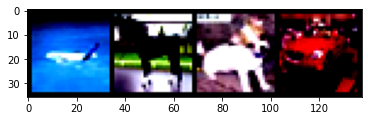

In [5]:
data_iterator = iter(dataloader) # Creacion de un iterador
imgs, labels = data_iterator.next() #obtencion de data

classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck'] # las mismas por defecto del modelo

plt.imshow(utils.make_grid(imgs).permute(1, 2, 0))

for i in range(size):
  print(classes[labels[i]])

In [6]:
#classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
class_names = ['car', 'cat'] # Uso de solo 2

label_map = {1: 0, 3: 1}

data_set = [(img, label_map[label]) for img, label in full_data_set if label in [1, 3]]
validation_set = [(img, label_map[label]) for img, label in full_validation_set if label in [1, 3]]

In [7]:
# Utilizando los datos de shape, se crea un modelo

mg, label = data_set[20]
img.shape

torch.Size([3, 32, 32])

In [8]:
# Creacion de un modelo lineal
# 512 es un numero arbitrario, este numero es el numero de salidas/neuronas para cada input
model = nn.Sequential(
            nn.Linear(3 * 32 * 32, 512),
            nn.Tanh(),
            nn.Linear(512, 2))

In [9]:
# Transformar resultado en una probabilidad 
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

In [10]:
x = torch.tensor([1.0, 2.0, 3.0])

sigmoid(x)

tensor([0.7311, 0.8808, 0.9526])

In [11]:
sigmoid(x).sum()

tensor(2.5644)

In [12]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [13]:
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [14]:
softmax(x).sum()

tensor(1.)

In [15]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [16]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'car'

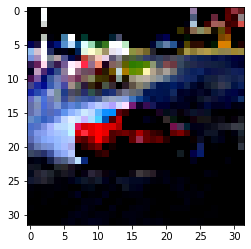

In [17]:
img, label = data_set[20]

plt.imshow(img.permute(1, 2, 0))
class_names[label]

In [18]:
out = model(img.view(-1).unsqueeze(0))
out

tensor([[0.4500, 0.5500]], grad_fn=<SoftmaxBackward>)

In [19]:
_, index = torch.max(out, dim=1)

print('->',class_names[label],' model:',class_names[index])

-> car  model: cat


In [20]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 110.0]])

softmax(x)

tensor([[0., 1.]])

In [21]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [22]:
log_softmax(x)

tensor([[-110.,    0.]])

In [23]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

# Implementando un clasificador totalmente conectado

In [24]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

loss = nn.NLLLoss()

In [27]:
# Verificar resultado

img, label = data_set[20]

out = model(img.view(-1).unsqueeze(0))

_, index = torch.max(out, dim=1)

print('->',class_names[label],' model:',class_names[index])

print(out)

loss(out, torch.tensor([label]))



-> car  model: car
tensor([[-0.5608, -0.8457]], grad_fn=<LogSoftmaxBackward>)


tensor(0.5608, grad_fn=<NllLossBackward>)

In [28]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

In [29]:
learning_rate = 0.01

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

lossFunction = nn.NLLLoss()

n_epochs = 5 #100

for epoch in range(n_epochs):
    for img, label in data_set:
        out = model(img.view(-1).unsqueeze(0))
        loss = lossFunction(out, torch.tensor([label]))
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.015207
Epoch: 1, Loss: 0.000105
Epoch: 2, Loss: 0.014995
Epoch: 3, Loss: 0.029179
Epoch: 4, Loss: 0.001092


In [30]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))


optimizer = optim.SGD(model.parameters(), lr=0.02)

loss_function = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.574126
Epoch: 1, Loss: 0.263976
Epoch: 2, Loss: 0.384328
Epoch: 3, Loss: 0.247331
Epoch: 4, Loss: 0.250660
Epoch: 5, Loss: 0.404244
Epoch: 6, Loss: 0.219994
Epoch: 7, Loss: 0.141190
Epoch: 8, Loss: 0.240192
Epoch: 9, Loss: 0.192785
Epoch: 10, Loss: 0.135266
Epoch: 11, Loss: 0.264496
Epoch: 12, Loss: 0.191565
Epoch: 13, Loss: 0.144362
Epoch: 14, Loss: 0.705397
Epoch: 15, Loss: 0.074092
Epoch: 16, Loss: 0.017689
Epoch: 17, Loss: 0.047854
Epoch: 18, Loss: 0.019398
Epoch: 19, Loss: 0.085561
Epoch: 20, Loss: 0.073846
Epoch: 21, Loss: 0.022848
Epoch: 22, Loss: 0.065451
Epoch: 23, Loss: 0.082047
Epoch: 24, Loss: 0.061348
Epoch: 25, Loss: 0.056304
Epoch: 26, Loss: 0.009846
Epoch: 27, Loss: 0.036185
Epoch: 28, Loss: 0.016698
Epoch: 29, Loss: 0.016050
Epoch: 30, Loss: 0.032763
Epoch: 31, Loss: 0.064395
Epoch: 32, Loss: 0.038736
Epoch: 33, Loss: 0.016391
Epoch: 34, Loss: 0.011656
Epoch: 35, Loss: 0.014838
Epoch: 36, Loss: 0.006238
Epoch: 37, Loss: 0.020808
Epoch: 38, Loss: 0.010

In [ ]:
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]

        correct += int((predicted == labels).sum())
      
print("Accuracy: %f" % (correct / total))

In [ ]:
img, label = validation_set[20]
out = model(img.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)

print('->: ',class_names[label],' model:',class_names[index])
plt.imshow(img.permute(1, 2, 0))
plt.show()

# Mejoras, limitaciones y conclusiones

In [ ]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

# Se retipe varias veces para mejorar el desempeño, pero tardara más tiempo

learning_rate = 0.01

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

In [ ]:
# Evaluacion de desempeño

val_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

In [ ]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

In [ ]:
img, label = validation_set[1]
out = model(img.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)

print('correct: ',class_names[label],' model:',class_names[index])
plt.imshow(img.permute(1, 2, 0))

In [ ]:
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

In [ ]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

sum([p.numel() for p in first_model.parameters()])

In [ ]:
sum([p.numel() for p in nn.Linear(3072, 512).parameters()])

In [ ]:
sum([p.numel() for p in nn.Linear(3072, 1024).parameters()])

In [ ]:
image = request.urlretrieve('https://i.pinimg.com/originals/43/bc/47/43bc47066bb8b2fa4fe7cc8e82cc3714.jpg','test,jpg')
                            
img = Image.open(image[0])

preprocess = transforms.Compose([
        transforms.Resize(48),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4915, 0.4823, 0.4468],
            std=[0.2470, 0.2435, 0.2616]
        )])

img_t = preprocess(img)
out = model(img_t.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)
print('correct: car ',' model:',class_names[index])
plt.imshow(img_t.permute(1, 2, 0))